# Motivation, why gradient should be a thing!

- In which papers is this hinted?
- Why not just jumping from one place to the next?


- What constitutes a good path?
    - the shortest path? (if points A and B are well defined)
    - Along the gradient? - Would this not get stuck in a local minima? - case in which A is defined, but destination B is hypothetical. 
    - maximizing availability to data (aside of some categories)?


    
Smootheness of camera movement?

In [3]:
from utils.gradient_walk_utils import query_locations

# al_df, debugging_list = query_locations([0,.5,.5,0], 3, projected_path=None, debugging_return=True)
# achieved_loc, perc_pred, tr, gn, prds, lstr, ps = debugging_list[0]
# query_locations([0,.5,.5,0], 3, projected_path=True, max_steps = 100)


# al_df = query_locations([0,1,0,0], 1000, lt=.5, debugging=True, max_steps=10)
al_df = query_locations([0,1,0,0], 5, lt=.5, debugging=True, max_steps=10)
# achieved_loc, perc_pred, tr, gn, prds, lstr, ps = debugging_list[0]

al_df.head()

  8%|████████▊                                                                                                     | 4/50 [00:00<00:02, 22.65it/s]


,x,y,z,xh,yh,zh,f_xyz,residual,steps,start_locs
0,510.392272,-9.302419,273.367834,183.362079,-26.505721,190.308445,"[0.03, 0.65, 0.07, 0.29]",0.183734,3,"[614.660903491211, 106.9097518920898, 222.3374..."
1,473.247252,102.936362,282.896581,-172.976514,-26.782629,-172.671230,"[0.08, 0.54, 0.06, 0.35]",0.237205,1,"[425.6770935058594, 57.31066894531245, 238.279..."
2,180.738463,73.937985,727.666357,-3.198767,0.122591,2.727945,"[0.36, 0.0, 0.34, 0.2]",0.477108,9,"[128.07272649023437, 61.92591857910139, 777.86..."
3,528.842955,109.262419,1374.969763,-19.315121,20.296716,-9.884805,"[0.03, 0.16, 0.59, 0.09]",0.388574,9,"[512.4059445800781, 92.41173934936492, 1459.27..."
4,2912.981017,-0.688180,753.140783,-7.943850,88.195779,-5.784535,"[0.22, 0.42, 0.03, 0.34]",0.289773,1,"[2853.2402990722658, 58.738909721374334, 811.7..."


# Color Scene by label categories and label pallete: VIS 2024 figure

In [ ]:
from utils.gradient_walk_utils import analyze_queried_locations
analyze_queried_locations(al_df, n_colors = 5, res_filter_threshold = .5)


import matplotlib.pyplot as plt
al_df["residual"].hist()
plt.title(f"Unconstrained residuals distirbution")

# Color Scene by label categories and label pallete: VIS 2024 figure

Development code Moved to `utils.gradient_walk_utils.analyze_queried_locations`

In [1]:
import open3d as o3d
import numpy as np
import seaborn as sns


from utils.scripts.archive.scene_loading_2 import get_highlighed_o3d_locations
from utils.scripts.interest_heuristic_0    import get_o3d_pcd_from_coordinates

from utils.gradient_walk_utils import process_locations_visibility_data_frame

def analyze_queried_locations(al_df=None, n_colors = 5, res_filter_threshold = .5, draw_o3d=True):
    """Invistigate queried locations Color Scene by label categories and label pallete: VIS 2024 figure"""
    vis_df, normp, _   = process_locations_visibility_data_frame("./utils/assets/test_data/locations_example.csv")

    
    targets_array = ((np.vstack(vis_df["f_xyz"])+1)/2)
    locs_array    = (vis_df.values)[:,:3]
    start_locs    = locs_array#np.vstack(al_df["start_locs"].values)[:,:3]#np.vstack([l[0] for l in locations])[:,:3]
    start_targets = ((np.vstack(vis_df["f_xyz"])+1)/2)#np.array([t[0] for t in targets])
    
    if al_df is not None:
        achieved_locs = al_df.values[:,:3]#np.vstack([l[1] for l in locations])[:,:3]
        mean_losses   = np.array(al_df["residual"].values)
        scaled_residuals = mean_losses / mean_losses.max()
        filtered_ids  = np.where(scaled_residuals<res_filter_threshold)[0] #np.where(np.array(mean_losses)<.5)[0]
        #err_pallete = sns.color_palette("coolwarm", n_colors=n_colors)
        #err_pallete = sns.diverging_palette(125, 5, as_cmap=False, n=n_colors, s=60)# Greento Red
        err_pallete = sns.diverging_palette(260, 5, as_cmap=False, n=n_colors, s=60) # Blue to Red
        loss_colors = np.array([err_pallete[int(ml*n_colors)-1] for ml in scaled_residuals])

    ###Label colors pallete
    label_pallete        = sns.color_palette("tab10", n_colors=4) #[Buildings, Water, Trees, Sky]
    label_pallete[1]     = label_pallete[0]; label_pallete[0] = (0.549, 0.471, 0.318); label_pallete[3] = (1, 0.847, 0.012) #ffd803
    full_dominant_label  = np.argmax(targets_array > np.array(targets_array).mean(axis=0), axis=1)
    #start_dominant_label = np.argmax(start_targets > start_targets.mean(axis=0), axis=1)
    #start_label_colors = np.take(label_pallete, start_dominant_label, axis=0)
    full_locs = locs_array[:,:3][full_dominant_label!=3]
    full_label_colors  = np.take(label_pallete, full_dominant_label, axis=0)[full_dominant_label!=3]
    # full_label_colors = np.hstack([full_label_colors, np.ones((full_label_colors.shape[0], 1))*.2])

    #O3D point cloud assembly:
    # full_pcd      = get_o3d_pcd_from_coordinates(locs_array[:,:3], [0,1,0])
    full_pcd      = get_o3d_pcd_from_coordinates(full_locs, full_label_colors)
    # start_pcd     = get_o3d_pcd_from_coordinates(start_locs, [0,1,0])
    # start_pcd    = get_o3d_pcd_from_coordinates(start_locs, start_label_colors)
    geometries = [full_pcd]
    
    if al_df is not None:
        adapted_pcd  = get_o3d_pcd_from_coordinates(achieved_locs, loss_colors)
        filtered_pcd = get_o3d_pcd_from_coordinates(achieved_locs[filtered_ids], loss_colors[filtered_ids])
        geometries.append(filtered_pcd)

    if draw_o3d:
        # o3d.visualization.draw_geometries([start_pcd])
        # o3d.visualization.draw_geometries([full_pcd])
        # o3d.visualization.draw_geometries([full_pcd, adapted_pcd])
        o3d.visualization.draw_geometries(geometries)

    return geometries

# analyze_queried_locations(al_df), 
analyze_queried_locations(None)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


[PointCloud with 22435 points.]

In [27]:
import open3d as o3d
import numpy as np
import seaborn as sns


from utils.scripts.archive.scene_loading_2 import get_highlighed_o3d_locations
from utils.scripts.interest_heuristic_0    import get_o3d_pcd_from_coordinates

from utils.gradient_walk_utils import *
vis_df, normp, _   = process_locations_visibility_data_frame("./utils/assets/test_data/locations_example.csv")

res_filter_threshold = .5
targets_array = ((np.vstack(vis_df["f_xyz"])+1)/2)
locs_array    = (vis_df.values)[:,:3]
start_locs    = locs_array#np.vstack(al_df["start_locs"].values)[:,:3]#np.vstack([l[0] for l in locations])[:,:3]
start_targets = ((np.vstack(vis_df["f_xyz"])+1)/2)#np.array([t[0] for t in targets])
achieved_locs = al_df.values[:,:3]#np.vstack([l[1] for l in locations])[:,:3]
mean_losses   = np.array(al_df["residual"].values)
scaled_residuals = mean_losses / mean_losses.max()
filtered_ids  = np.where(scaled_residuals<res_filter_threshold)[0] #np.where(np.array(mean_losses)<.5)[0]

n_colors = 5
err_pallete = sns.color_palette("coolwarm", n_colors=n_colors)
err_pallete = sns.diverging_palette(125, 5, as_cmap=False, n=n_colors, s=60)# Greento Red
err_pallete = sns.diverging_palette(260, 5, as_cmap=False, n=n_colors, s=60) # Blue to Red
loss_colors = np.array([err_pallete[int(ml*n_colors)-1] for ml in scaled_residuals])

###Label colors pallete
label_pallete = sns.color_palette("tab10", n_colors=4)
label_pallete[1] = label_pallete[0]
label_pallete[0] = (0.549, 0.471, 0.318)
label_pallete[3] = (1, 0.847, 0.012) #ffd803
start_dominant_label = np.argmax(start_targets > start_targets.mean(axis=0), axis=1)
full_dominant_label = np.argmax(targets_array > np.array(targets_array).mean(axis=0), axis=1)
start_label_colors = np.take(label_pallete, start_dominant_label, axis=0)

full_locs = locs_array[:,:3][full_dominant_label!=3]
full_label_colors  = np.take(label_pallete, full_dominant_label, axis=0)[full_dominant_label!=3]
# full_label_colors = np.hstack([full_label_colors, np.ones((full_label_colors.shape[0], 1))*.2])

#O3D point cloud assembly:
# full_pcd      = get_o3d_pcd_from_coordinates(locs_array[:,:3], [0,1,0])
full_pcd      = get_o3d_pcd_from_coordinates(full_locs, full_label_colors)
# start_pcd     = get_o3d_pcd_from_coordinates(start_locs, [0,1,0])
start_pcd     = get_o3d_pcd_from_coordinates(start_locs, start_label_colors)
adapted_pcd  = get_o3d_pcd_from_coordinates(achieved_locs, loss_colors)
filtered_pcd = get_o3d_pcd_from_coordinates(achieved_locs[filtered_ids], loss_colors[filtered_ids])


# o3d.visualization.draw_geometries([start_pcd])
# o3d.visualization.draw_geometries([full_pcd])
# o3d.visualization.draw_geometries([full_pcd, adapted_pcd])
o3d.visualization.draw_geometries([full_pcd, filtered_pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Deprecated
# Project trajectory points on planes

Quick links:

- How to project a point onto a plane in 3D? https://stackoverflow.com/a/9605695

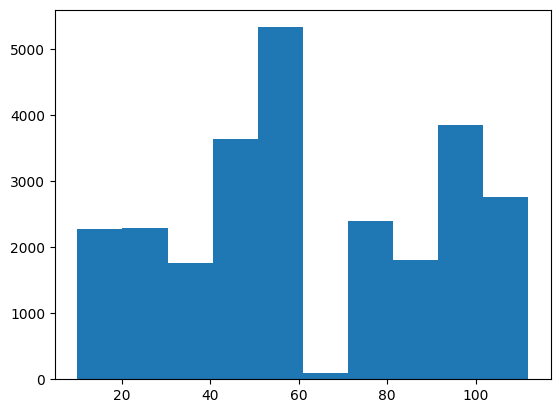

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [6]:
import open3d as o3d
import numpy as np
from utils.scripts.archive.scene_loading_2 import get_highlighed_o3d_locations
from utils.scripts.interest_heuristic_0    import get_o3d_pcd_from_coordinates
from utils.scripts.architectures.train_location_encoder import process_locations_visibility_data_frame


vis_df, normp, _   = process_locations_visibility_data_frame("./utils/assets/test_data/locations_example.csv")
locs_array    = vis_df.values[:,:3].astype(float)

locs_array
get_o3d_pcd_from_coordinates(locs_array, colors=[1, 0.5, 0])
# o3d.visualization.draw_geometries([get_o3d_pcd_from_coordinates(locs_array, colors=[1, 0.5, 0])])

#Determine manually the planes:
import matplotlib.pyplot as plt
plt.hist(locs_array[:,1])
plt.show()

#Split locations in multiple planes
plane1 = locs_array[np.where(locs_array[:,1] < 55)]
plane2 = locs_array[np.where(locs_array[:,1] > 55)]

# Display planes in different colors:
import seaborn as sns
err_pallete = sns.color_palette("coolwarm", n_colors=2)
plane1_pcd = get_o3d_pcd_from_coordinates(plane1, colors=err_pallete[0])
plane2_pcd = get_o3d_pcd_from_coordinates(plane2, colors=err_pallete[1])
o3d.visualization.draw_geometries([plane1_pcd, plane2_pcd])



In [7]:
from utils.gradient_walk_utils import find_plane

mins = locs_array.min(axis=0)[:3]
maxs = locs_array.max(axis=0)[:3]
plane_equation1, project_point1 = find_plane(plane1, mins, maxs)
print("Equation of the plane 1:", plane_equation1)


plane_equation2, project_point2 = find_plane(plane2, mins, maxs)
print("Equation of the plane 2:", plane_equation2)

ImportError: cannot import name 'find_plane' from 'utils.gradient_walk_utils' (/Users/stefancobeli/Desktop/Research/Visibility_Encoder/utils/gradient_walk_utils.py)

# Visualization of point projected on closest plane:

In [2]:
import numpy as np
from utils.gradient_walk_utils import find_plane

new_point = np.array([300, -1000, 1000])
projected_point1 = project_point1(new_point)
t1 = np.linalg.norm(new_point-projected_point1)
projected_point2 = project_point2(new_point)
t2 = np.linalg.norm(new_point-projected_point2)
print(f"Projected point onto the planes with distances 1:{t1:.2f} 2:{t2:.2f}:\n\t", projected_point1, projected_point2)

dist_pallete = [err_pallete[i] for i in np.argsort([t1, t2])]


o3d.visualization.draw_geometries([] 
    +[get_o3d_pcd_from_coordinates(locs_array, colors=[.5, 0.25, .25])]\
         + get_highlighed_o3d_locations(projected_point1, color=dist_pallete[0], npoints=1000, radius=10)
         + get_highlighed_o3d_locations(projected_point2, color=dist_pallete[1], npoints=1000, radius=10)
         + get_highlighed_o3d_locations(new_point, color=(0,0,1), npoints=1000, radius=10)
             )

ImportError: cannot import name 'find_plane' from 'utils.gradient_walk_utils' (/Users/stefancobeli/Desktop/Research/Visibility_Encoder/utils/gradient_walk_utils.py)

Getting gradient with respect to input positions:

See Page 4/9 in iNeRF - A. Gradient-Based SE(3) Optimization

"We iteratively differentiate the loss function through the MLP to obtain the gradient 

∇SθL(e[S]θT0 | I,Θ) 

that is used to update the estimated relative transformation"

In [10]:
import numpy as np
np.min([locs_array.min(axis=0), locs_array.max(axis=0)], axis = 0)

array([ 0.45397061, 10.        ,  7.69332218])

In [11]:
import numpy as np
projected_point = [6087.26009576,   -37.42636613, 2791.23803085]
mins            = [ 0.45397061, 10.,          7.69332218]
maxs            = [3001.7009021,   111.92591858, 2170.65]


print(projected_point, mins, maxs)
projected_point = np.min([maxs, projected_point], axis = 0)
projected_point = np.max([mins, projected_point], axis = 0)
print(projected_point, mins, maxs)


[6087.26009576, -37.42636613, 2791.23803085] [0.45397061, 10.0, 7.69332218] [3001.7009021, 111.92591858, 2170.65]
[3001.7009021   10.        2170.65     ] [0.45397061, 10.0, 7.69332218] [3001.7009021, 111.92591858, 2170.65]


In [6]:
from utils.gradient_walk_utils import query_locations

al_df, debugging_list = query_locations([0,.5,.5,0], 3, projected_path=None, debugging_return=True)
achieved_loc, perc_pred, tr, gn, prds, lstr, ps = debugging_list[0]
# query_locations([0,.5,.5,0], 3, projected_path=True, max_steps = 100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.31it/s]


In [7]:
tr

[array([614.66090349, 106.90975189, 222.33747405, 169.27866261,
        -13.3054326 , 177.50494015]),
 array([611.65972786, 103.908503  , 219.33627862, 169.63864457,
        -13.66543432, 177.86493293]),
 array([612.3999012 , 100.9135117 , 218.8799798 , 169.99901139,
        -13.97186895, 178.21223822]),
 array([614.38104133,  97.96498723, 217.96726007, 170.36009538,
        -14.27881856, 178.42589179]),
 array([614.66479377,  95.00313038, 216.12180108, 170.72227799,
        -14.60504766, 178.59140387]),
 array([615.52221565,  92.02045865, 213.86246271, 171.08594071,
        -14.94129033, 178.71707526]),
 array([615.5608509 ,  89.01272816, 211.42709894, 171.45138871,
        -15.28590246, 178.76900092]),
 array([616.52014045,  85.97813267, 208.81448907, 171.81854569,
        -15.63657995, 178.77571479]),
 array([615.67932014,  83.04114575, 208.67972345, 172.18117082,
        -15.98987813, 178.74563971]),
 array([614.14794807,  80.25826306, 209.78513116, 172.53490006,
        -16.349176

In [2]:
al_df, debugging_list = query_locations([.4,.6,0,0], 3, projected_path=True, debugging_return=True)
achieved_loc, perc_pred, tr, gn, prds, lstr, ps= debugging_list[0]

  0%|                                                                                                                          | 0/30 [00:00<?, ?it/s]/Users/stefancobeli/Desktop/Research/Visibility_Encoder/utils/gradient_walk_utils.py:201: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  input_pos       = torch.autograd.Variable(torch.tensor([np.array(projected_input).astype(np.float32)]), requires_grad=True)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.85it/s]


In [3]:
import numpy as np
from utils.scripts.interest_heuristic_0    import get_o3d_pcd_from_coordinates
import open3d as o3d


np_trajectory    = np.vstack(tr)[:,:3]
trajectory_pcd  = get_o3d_pcd_from_coordinates(np_trajectory)

o3d.visualization.draw_geometries([trajectory_pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [ ]:
from utils.gradient_walk_utils import query_locations

query_locations([0,.5,.5,0], 2)

import pandas as pd
# pd.DataFrame([[[0,1,0,0], 2, 1]], columns=["f_xyz", "num_locations", "seed"]).to_json("location.json", orient="records", indent=4)

pd.DataFrame([[[0,1,0,0], 2]], columns=["f_xyz", "num_locations"]).to_json("location.json", orient="records", indent=4)



# !!!!

# Stand alone working snippets:


# Training set statistics on inter points losses

In [3]:
import pandas as pd
import numpy as np
# vis_df = pd.read_csv("./utils/assets/test_data/locations_example.csv")
# rmb_df = pd.read_csv("./utils/assets/removed_buildings/removedBuilding.csv")

from utils.scripts.architectures.train_location_encoder import process_locations_visibility_data_frame
from utils.scripts.architectures.train_location_encoder import rescale_from_norm_params
from utils.gradient_walk_utils import initialize_trained_encoder

from utils.gradient_walk_utils import gradient_walk

import torch
from tqdm.notebook import tqdm
criterion                  = torch.nn.MSELoss(reduction='none')


trained_encoder, info_dict = initialize_trained_encoder()

def tanh_mse_loss_to_per_class_percentage(mean_loss):
    """tanh_mse_loss_to_per_class_percentage"""
    mse  = (mean_loss) / 2
    perc = mse ** .5
    return mse, perc
tmlcp = tanh_mse_loss_to_per_class_percentage

print("Trained encoder with mean loss of: ", info_dict["final_test_loss"])
print("Percentage MSE %.4f and RMSE:  %.4f" \
      %tanh_mse_loss_to_per_class_percentage(info_dict["final_test_loss"]))


vis_df, normp, _   = process_locations_visibility_data_frame("./utils/assets/test_data/locations_example.csv")
rmb_df, _, _       = process_locations_visibility_data_frame("./utils/assets/removed_buildings/removedBuilding.csv", normp)

locs_array    = vis_df.values[:,:6].astype(float)
# targets_array = torch.tensor(np.vstack((vis_df["f_xyz"])))
targets_array = (np.vstack((vis_df["f_xyz"]))).tolist()


rmb_l_array = rmb_df.values[:,:6].astype(float)
rmb_t_array = torch.tensor(np.vstack((rmb_df["f_xyz"])))
rmb_t_array = (np.vstack((rmb_df["f_xyz"]))).tolist()

locs_array.shape, rmb_l_array.shape, locs_array[:2].round(1)

Trained encoder with mean loss of:  0.018627514497741554
Percentage MSE 0.0093 and RMSE:  0.0965


((26232, 6),
 (12804, 6),
 array([[ 592.7,   51.7,  104.6,  170.4,    4.1, -179.3],
        [ 592.7,  101.7,  104.6,  172.6,    4.1, -179.5]]))

In [4]:
np.random.seed(1)
lt = .01#25#.01#1 #loss_threshold

num_ps      = [] #number performed_steps
mean_losses = [] # final mean losses for each pair input target
targets     = [] #(start, achieved, desired)
locations   = [] #(start, achieved, desired)
#rd_ids = []
#inputs      = [] # Trajectory of inputs
spatial_differences = [] #(initial, final)

n_trials  = 1000#10
max_steps = 25#100

custom_target_d = None
# custom_target_d = [0, .4, .4, .1] #None
custom_target_d = [0, 1, 0, 0] #None
# custom_target_d = [0, 0, 1, 0] #None
# custom_target_d = [0, .5, .5, 0] #None
custom_target_d = (np.array(custom_target_d) * 2 - 1).tolist() #None

search_intervals = np.ones(4) * .2
# search_intervals = None

for i in tqdm(range(n_trials)):
    crt_id = np.random.randint(0, len(targets_array))
    #for j in range(n_trials):
    des_id = np.random.randint(0, len(targets_array))
    #rd_ids += [crt_id, des_id]

    actual_loc, actual_target   = locs_array[crt_id], targets_array[crt_id]
    #inputs.append((actual_target))
    if custom_target_d is None:
        desired_loc, desired_target = locs_array[des_id], targets_array[des_id]
    else: 
        desired_loc    = None
        desired_target = custom_target_d
    #desired_target = (np.array([0, .4, .4, .1]) * 2 - 1).tolist()

    achieved_loc, perc_pred, tr, gn, prds, lstr, ps, fr = gradient_walk(actual_loc, desired_target, search_intervals, max_steps, lt, True)

    locations.append((actual_loc, achieved_loc, desired_loc))
    #actual_loc = achieved_loc
    
    
    num_ps.append(ps)
    mean_losses.append(lstr[-1].mean())
    #actual_target =
    #desired_target = 

    start    =  [(at+1)/2 for at in actual_target]
    achieved =  perc_pred
    desired  =  [(dt+1)/2 for dt in desired_target]
    targets.append([np.round(t, 2) for t in [start, achieved, desired]])

    
##### Print stats about the discovered locations:

print(np.mean(mean_losses))


# rd_ids
#prediction, labes, interval_target

  0%|          | 0/1000 [00:00<?, ?it/s]

0.6081167


In [10]:
al_df = pd.DataFrame(columns=["x", "y", "z", "xh", "yh", "zh", "f_xyz", "residuals"])
al_df[["x", "y", "z", "xh", "yh", "zh"]] = np.vstack([(l[1]) for l in locations]).astype(str)
# al_df["f_xyz"] = np.vstack([[t[1]] for t in targets])
# al_df["f_xyz"]     = al_df["x"].apply(lambda x: "[0 1 0 0]")
al_df["f_xyz"]     = al_df.apply(lambda x: str(np.array(targets[x.name][1])), axis=1)
al_df["residuals"] = mean_losses

al_df
print(al_df[:2].to_json(orient="records", indent=4))

[
    {
        "x":"637.1823108640624",
        "y":"-104.69192271582031",
        "z":"531.5575920998438",
        "xh":"201.72719132359376",
        "yh":"-10.912268117148436",
        "zh":"204.65997687246093",
        "f_xyz":"[0.01 0.89 0.08 0.04]",
        "residuals":0.0110842511
    },
    {
        "x":"181.5416858640624",
        "y":"74.64675755151367",
        "z":"753.2197319924219",
        "xh":"-2.658283835097656",
        "yh":"-7.963041737753905",
        "zh":"11.618425282495117",
        "f_xyz":"[0.17 0.   0.39 0.21]",
        "residuals":1.2261868715
    }
]


# Color Scene by label categories and label pallete: VIS 2024 figure

In [5]:
import open3d as o3d
import seaborn as sns


from utils.scripts.archive.scene_loading_2 import get_highlighed_o3d_locations
from utils.scripts.interest_heuristic_0    import get_o3d_pcd_from_coordinates


start_locs    = np.vstack([l[0] for l in locations])[:,:3]
achieved_locs = np.vstack([l[1] for l in locations])[:,:3]
filtered_ids  = np.where(np.array(mean_losses)<.5)[0]
start_targets = np.array([t[0] for t in targets])

n_colors = 10
err_pallete = sns.color_palette("coolwarm", n_colors=n_colors)
err_pallete = sns.diverging_palette(125, 5, as_cmap=False, n=n_colors, s=60)# Greento Red
err_pallete = sns.diverging_palette(260, 5, as_cmap=False, n=n_colors, s=60) # Blue to Red
loss_colors = np.array([err_pallete[int(ml*5)] for ml in mean_losses])

###Label colors pallete
label_pallete = sns.color_palette("tab10", n_colors=4)
label_pallete[1] = label_pallete[0]
label_pallete[0] = (0.549, 0.471, 0.318)
label_pallete[3] = (1, 0.847, 0.012) #ffd803
start_dominant_label = np.argmax(start_targets > start_targets.mean(axis=0), axis=1)
full_dominant_label = np.argmax(targets_array > np.array(targets_array).mean(axis=0), axis=1)
start_label_colors = np.take(label_pallete, start_dominant_label, axis=0)

full_locs = locs_array[:,:3][full_dominant_label!=3]
full_label_colors  = np.take(label_pallete, full_dominant_label, axis=0)[full_dominant_label!=3]
# full_label_colors = np.hstack([full_label_colors, np.ones((full_label_colors.shape[0], 1))*.2])

#O3D point cloud assembly:
# full_pcd      = get_o3d_pcd_from_coordinates(locs_array[:,:3], [0,1,0])
full_pcd      = get_o3d_pcd_from_coordinates(full_locs, full_label_colors)
# start_pcd     = get_o3d_pcd_from_coordinates(start_locs, [0,1,0])
start_pcd     = get_o3d_pcd_from_coordinates(start_locs, start_label_colors)
adapted_pcd  = get_o3d_pcd_from_coordinates(achieved_locs, loss_colors)
filtered_pcd = get_o3d_pcd_from_coordinates(achieved_locs[filtered_ids], loss_colors[filtered_ids])


o3d.visualization.draw_geometries([start_pcd])
# o3d.visualization.draw_geometries([full_pcd])
# o3d.visualization.draw_geometries([full_pcd, adapted_pcd])
o3d.visualization.draw_geometries([full_pcd, filtered_pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [24]:
f=[ -0.41, -0.32, -0.85 ];l=[ 1136.07, 245.83, 1283.71 ];u=[ 0.05, -0.94, 0.33 ];z=0.5

full_pcd      = get_o3d_pcd_from_coordinates(full_locs, [.8,.8,.8])

o3d.visualization.draw_geometries([start_pcd], front=f, lookat=l, up=u, zoom=z)
full_pcd      = get_o3d_pcd_from_coordinates(full_locs, full_label_colors)
o3d.visualization.draw_geometries([full_pcd], front=f, lookat=l, up=u, zoom=z)

full_pcd      = get_o3d_pcd_from_coordinates(full_locs, [.8,.8,.8])
o3d.visualization.draw_geometries([full_pcd, filtered_pcd], front=f, lookat=l, up=u, zoom=z)



[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [17]:
start_targets = np.array([t[0] for t in targets])

start_targets.shape, start_locs.shape

((1000, 4), (1000, 3))

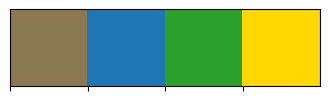

In [37]:
label_pallete = sns.color_palette("tab10", n_colors=4)

label_pallete[1] = label_pallete[0]
label_pallete[0] = (0.549, 0.471, 0.318)
label_pallete[3] = (1, 0.847, 0.012) #ffd803

dominant_label = np.argmax(start_targets > start_targets.mean(axis=0), axis=1)

label_colors = np.take(label_pallete, dominant_label, axis=0)

sns.palplot(label_pallete)

# Two main approaches to find a desired_target:
- search intervals and enforce hypothetical target;
- compare hypothetical target to all tragets in training set. Use gradient towards target from training set with small KL divergence with respect to hypothetical target.

 16%|████████████████████████▌                                                                                                                               | 81/500 [00:06<00:33, 12.47it/s]

(50, 9)


,x,y,z,xh,yh,zh,f_xyz,residual,steps
0,620.036620,-144.229795,553.288610,199.783695,-10.982405,202.697315,"[0.01, 0.93, 0.06, 0.03]",0.042807,22
1,557.894774,121.516020,283.005102,-153.188580,-11.619032,-144.958263,"[0.03, 0.91, 0.03, 0.03]",0.043397,12
2,3079.251647,-30.897214,632.412054,-40.025975,124.277643,-33.112557,"[0.05, 0.9, 0.02, 0.06]",0.059137,74
3,2639.674987,-176.304533,1875.992284,-38.864052,81.403497,-7.025837,"[0.2, 0.76, 0.02, 0.09]",0.136743,74
4,943.200713,-21.801725,736.350347,-30.485325,56.560678,-13.253216,"[0.01, 0.93, 0.05, 0.03]",0.038152,14
5,724.808226,-62.005796,254.348791,214.102771,-2.688807,-167.513455,"[0.02, 0.91, 0.02, 0.05]",0.045208,74
6,959.370818,21.666754,485.169592,-32.460343,69.327920,-15.324844,"[0.01, 0.92, 0.03, 0.05]",0.042240,51
7,1758.824675,-62.199644,698.708196,-31.514302,30.968470,-41.574993,"[0.04, 0.86, 0.03, 0.05]",0.064992,74
8,2693.265441,-173.738447,877.594488,-32.792363,94.539259,-33.235579,"[0.18, 0.77, 0.01, 0.13]",0.135994,74
9,915.260070,145.330866,1426.277593,-32.952481,58.175806,-51.210365,"[0.02, 0.69, 0.12, 0.17]",0.153878,74


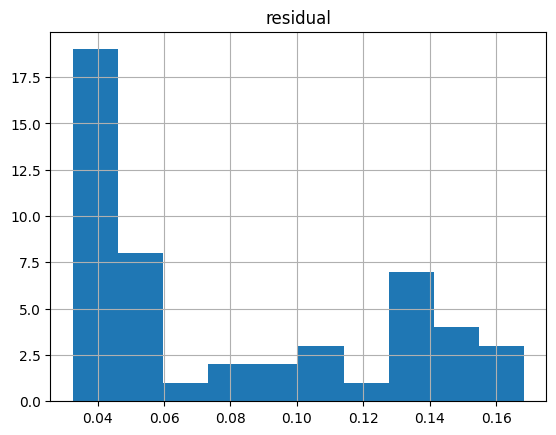

In [1]:
from utils.gradient_walk_utils import query_locations
import numpy as np

# print(query_locations([0,1,0,0], 2).to_json(orient="records", indent=4))

al_df = query_locations([0,1,0,0], 50, search_intervals=np.ones(4)*.01, lt=0.01, at=20, max_steps=75)

print(al_df.shape)
al_df.hist("residual")

al_df.head(10)

array([[<Axes: title={'center': 'steps'}>]], dtype=object)

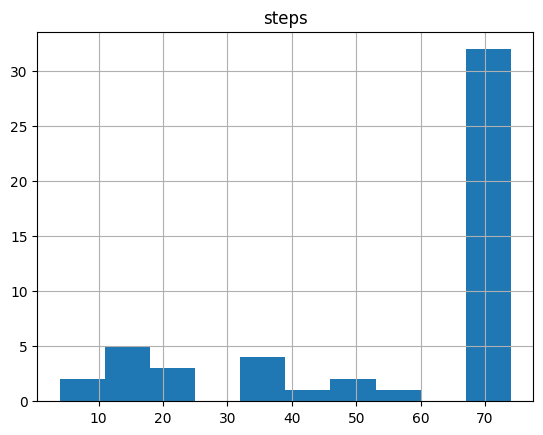

In [2]:

al_df.hist("steps")

array([[<Axes: title={'center': 'residual'}>]], dtype=object)

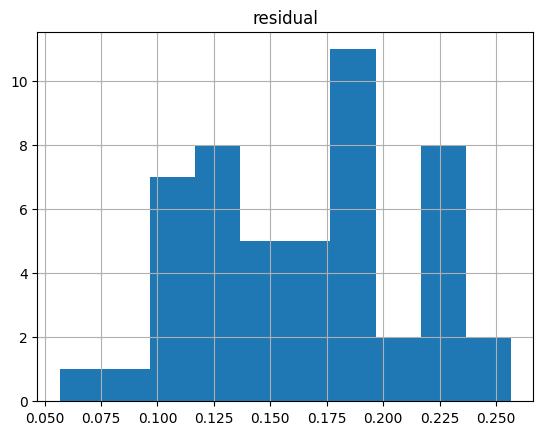

In [3]:
al_df.hist("residual")

In [3]:
import torch 

torch.tensor([0,1,0,0]), torch.tensor([0.01, 0.9, 0.06, 0.04])

(tensor([0, 1, 0, 0]), tensor([0.0100, 0.9000, 0.0600, 0.0400]))

In [8]:
des, act = torch.tensor([0,1,0,0]), torch.tensor([0.01, 0.9, 0.06, 0.04])

criterion                  = torch.nn.MSELoss(reduction='none')
# criterion                  = torch.nn.R(reduction='none')

criterion(des, act).mean(), criterion(des, act).mean()**.5\
, torch.sqrt(criterion(des, act)).mean(), torch.sqrt(criterion(des, act)).mean()**2

(tensor(0.0038), tensor(0.0618), tensor(0.0525), tensor(0.0028))

In [1]:
import pandas as pd
import numpy as np
# vis_df = pd.read_csv("./utils/assets/test_data/locations_example.csv")
# rmb_df = pd.read_csv("./utils/assets/removed_buildings/removedBuilding.csv")

from utils.scripts.architectures.train_location_encoder import process_locations_visibility_data_frame
from utils.scripts.architectures.train_location_encoder import rescale_from_norm_params
from utils.gradient_walk_utils import initialize_trained_encoder

from utils.gradient_walk_utils import gradient_walk

import torch
from tqdm.notebook import tqdm


def query_locations(desired_distribution, num_locations=10, search_intervals=np.ones(4) * .2, lt=.2, seed=1):
    '''
    search_intervals:  
    lt:                loss threshold
    return num_locations with desired_distribution plus minus the search_intervals with a loss threshold smaller than lt'''
    
    np.random.seed(seed)
    
    vis_df, normp, _   = process_locations_visibility_data_frame("./utils/assets/test_data/locations_example.csv")  
    locs_array         = vis_df.values[:,:6].astype(float)
    targets_array = (np.vstack((vis_df["f_xyz"]))).tolist()
    
    num_ps      = [] #number performed_steps
    mean_losses = [] # final mean losses for each pair input target
    targets     = [] #(achieved, desired)
    locations   = [] #(start, achieved)
    spatial_differences = [] #(initial, final)
    residuals   = []

    n_trials  = num_locations
    max_steps = 100

    custom_target_d = desired_distribution #Distribution in percentages 
    desired_target  = (np.array(custom_target_d) * 2 - 1).tolist() #Distribution in tanh


    for i in tqdm(range(n_trials * 10)):
        
        crt_id = np.random.randint(0, len(locs_array))
        
        #des_id = np.random.randint(0, len(targets_array))
        #rd_ids += [crt_id, des_id]

        actual_loc    = locs_array[crt_id]
        actual_target = targets_array[crt_id]

            
        achieved_loc, perc_pred, tr, gn, prds, lstr, ps, fr = gradient_walk(actual_loc, desired_target, search_intervals, max_steps, lt, True)

        if lstr[-1].mean() < lt:
            locations.append((actual_loc, achieved_loc))

            num_ps.append(ps)
            mean_losses.append(lstr[-1].mean())

            start    =  [(at+1)/2 for at in actual_target]
            achieved =  perc_pred
            desired  =  [(dt+1)/2 for dt in desired_target]
            targets.append([np.round(t, 2) for t in [achieved, desired]])
        
        if len(locations) >= num_locations:
            break
         
    #print(vis_df.columns.values)
    #print(vis_df.iloc[0])
    
    #print(pd.DataFrame(data=locations[0], columns=vis_df.columns.values[:6]))
    
    ach_locs = [l[1] for l in locations]
    al_df    = pd.DataFrame(data=ach_locs, columns=vis_df.columns.values[:6])#achived locations data frame
    
    al_df["f_xyz"]     = [t[0] for t in targets]
    al_df["residual"]  = residuals
    al_df["steps"]     = num_ps
    
    return al_df

print(query_locations([0,1,0,0], 2).to_json(orient="records", indent=4))


  0%|          | 0/20 [00:00<?, ?it/s]

0.020593633875250816 tensor([0., 1., 0., 0.]) tensor([0.0143, 0.7944, 0.1027, 0.1713])
0.03087294101715088 tensor([0., 1., 0., 0.]) tensor([0.0575, 0.6989, 0.0462, 0.1654])
[
    {
        "x":496.9694812742,
        "y":-32.3100333726,
        "z":288.8317620217,
        "xh":186.2677034086,
        "yh":-28.706297353,
        "zh":192.5462531176,
        "f_xyz":[
            0.0099999998,
            0.7900000215,
            0.1000000015,
            0.1700000018
        ],
        "residual":0.0205936339
    },
    {
        "x":512.4688709227,
        "y":120.5593437637,
        "z":298.4493157327,
        "xh":-163.6238066012,
        "yh":-20.0221466572,
        "zh":-159.9092369947,
        "f_xyz":[
            0.0599999987,
            0.6999999881,
            0.0500000007,
            0.1700000018
        ],
        "residual":0.030872941
    }
]


In [9]:
query_locations([0,.5,.5,0], 2)

  0%|          | 0/20 [00:00<?, ?it/s]

,x,y,z,xh,yh,zh,f_xyz
0,440.023803,43.190476,251.506078,-178.001675,-33.960242,-178.166576,"[0.02, 0.34, 0.3, 0.3]"
1,515.269286,89.596335,1436.671331,-11.123353,16.716114,-10.747158,"[0.03, 0.08, 0.56, 0.14]"


In [4]:
import open3d as o3d
import seaborn as sns


from utils.scripts.archive.scene_loading_2 import get_highlighed_o3d_locations
from utils.scripts.interest_heuristic_0    import get_o3d_pcd_from_coordinates


start_locs    = np.vstack([l[0] for l in locations])[:,:3]
achieved_locs = np.vstack([l[1] for l in locations])[:,:3]
filtered_ids  = np.where(np.array(mean_losses)<.5)[0]

n_colors = 10
err_pallete = sns.color_palette("coolwarm", n_colors=n_colors)
loss_colors = np.array([err_pallete[int(ml*5)] for ml in mean_losses])

full_pcd      = get_o3d_pcd_from_coordinates(locs_array[:,:3], [0,1,0])
start_pcd     = get_o3d_pcd_from_coordinates(start_locs, [0,1,0])
adapted_pcd  = get_o3d_pcd_from_coordinates(achieved_locs, loss_colors)
filtered_pcd = get_o3d_pcd_from_coordinates(achieved_locs[filtered_ids], loss_colors[filtered_ids])


o3d.visualization.draw_geometries([start_pcd])
o3d.visualization.draw_geometries([full_pcd, adapted_pcd])
o3d.visualization.draw_geometries([full_pcd, filtered_pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Algorithm for desired target search:

- check closest 100 points in training set according to KL div
- select randomly on of the 100 points as _adapted desired target_.


- Intialize points.

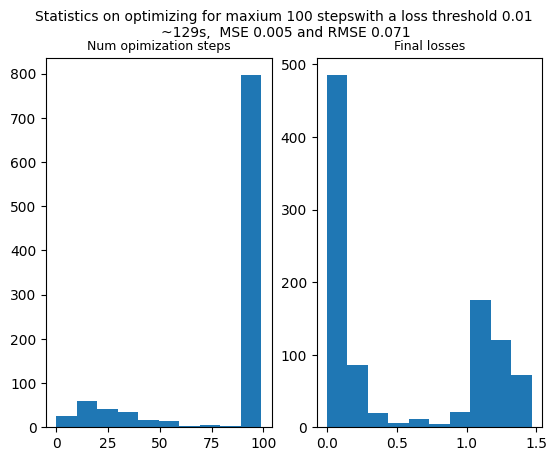

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax[0].hist(num_ps); ax[0].set_title("Num opimization steps", fontsize=9)
ax[1].hist(mean_losses); ax[1].set_title("Final losses", fontsize=9)

# sum(num_ps) / 360
plt.suptitle(f"Statistics on optimizing for maxium {max_steps} steps" \
             f"with a loss threshold {lt} \n"
             f"~{sum(num_ps) // 650}s,  MSE %.3f and RMSE %.3f\n" \
             f"{'Searching for {custom_target_d}'if custom_target_d is None else ''}"
             %tmlcp(lt), fontsize=10)


# ax[0].hist(num_ps)

# plt.grid(True)
fig.savefig(f'{lt}_{max_steps}_{n_trials}_{custom_target_d}.png')
plt.show()

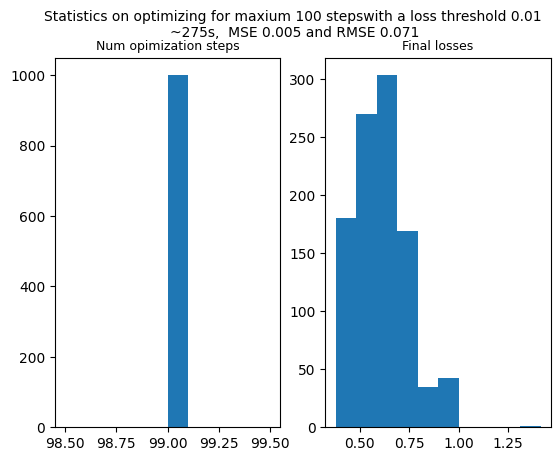

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax[0].hist(num_ps); ax[0].set_title("Num opimization steps", fontsize=9)
ax[1].hist(mean_losses); ax[1].set_title("Final losses", fontsize=9)

# sum(num_ps) / 360
plt.suptitle(f"Statistics on optimizing for maxium {max_steps} steps" \
             f"with a loss threshold {lt} \n"
             f"~{sum(num_ps) // 360}s,  MSE %.3f and RMSE %.3f\n" \
             f"{'Searching for {custom_target_d}'if custom_target_d is None else ''}"
             %tmlcp(lt), fontsize=10)


# ax[0].hist(num_ps)

# plt.grid(True)
fig.savefig(f'{lt}_{max_steps}_{n_trials}.png')
plt.show()

In [89]:
import numpy as np

# https://datascience.stackexchange.com/a/9264
# https://en.wikipedia.org/wiki/Kullback–Leibler_divergence#Definition

def KL(a, b):
    eps = 1e-8
    p = np.array(a) + eps
    q = np.array(b) + eps
#     p=p/2+1
#     q=q/2+1
    #print(a,b, np.log(a / b))

    return np.sum(np.where(p != eps, p * np.log(p / q), 0), axis=0)


values1 = [1.346112,1.337432,1.246655]
values2 = [1.033836,1.082015,1.117323]

print(KL(values1, values2))
print(KL(custom_target_d, custom_target_d))


0.7752796233941897
0.0


In [100]:
(np.array(targets_array[16647])+1)

array([-0.49973106, -0.5       , -0.17945957, -0.49854088])

In [71]:
np.array(targets_array)

array([[-0.98396111, -0.98882866, -0.47459793,  0.43447495],
       [-0.91848183, -0.78049278, -0.81696129,  0.4926033 ],
       [-0.98211098, -0.98875046, -0.45773888, -0.10448074],
       ...,
       [-0.34233665, -0.99995995, -0.84386063,  0.15462303],
       [ 1.        , -1.        , -1.        , -1.        ],
       [-0.11776161, -0.9999485 , -0.84516335, -0.06767082]])

# Cleaner Development Drafts

In [138]:
prediction = achieved; desired_target = desired; intervals = np.ones(4) * .15#.1#.05

def interval_desired_target_loss(prediction, desired_target, intervals):
    '''Compute target if prediction can be within interval of desired_target:
    interval_target = interval_desired_target_loss(prediction, desired_target, intervals)
    '''

    pred_in_interval = np.logical_and(prediction < desired_target + intervals, 
                                    prediction > desired_target - intervals)

    interval_target = torch.tensor(np.where(pred_in_interval, prediction, desired_target))
    
    return interval_target

prediction, desired_target, intervals, pred_in_interval\
, interval_desired_target_loss(prediction, desired_target, intervals)# interval_target

(array([0.1506536 , 0.5338762 , 0.18415096, 0.14912218], dtype=float32),
 [0, 0.4, 0.4, 0.1],
 array([0.15, 0.15, 0.15, 0.15]),
 array([ True,  True, False,  True]),
 array([0.        , 0.53387618, 0.4       , 0.14912218]))

# Working Plotting path on gradient

# Further Away locations - not working as well

In [8]:
import numpy as np
from tqdm.notebook import tqdm
#Buildings - location_single_-27_75_56_with_predictions
loc_B    = ([-28.18, 75.22, 56.60, -166.60, -54.17, -169.07])
loc_B    = ([-29.18, 74.22, 55.60, -166.60, -54.17, -169.07])
target_B = ([0.8818, 2.282e-05, 0.0364, 0.0305])

#Trees - location_single_161_60_96_with_predictions
loc_T    = ([162.98, 59.27, 96.73, 178.64, -59.61, 178.82])
target_T = ([0.7534, 5.9236e-07, 0.1012, 0.1453])

#Water - location_single_353_102_188_with_predictions
loc_W    = ([354.59, 103.53, 188.29, -167.69, -44.74, -171.26])
target_W = ([0.1380, 0.4763, 0.1468, 0.2387])

actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_T, target_T
# actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_W, target_W
# actual_loc, desired_target = (loc_A), target_T

In [9]:
actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_T, target_T
# actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_W, target_W

actual_loc, perc_pred, trajectory, gradients_norm, predictions, loss_trajectory, performed_steps = \
gradient_walk(actual_loc, desired_target, n_steps=100, debugging_return=True)

In [19]:
import open3d as o3d
import seaborn as sns


from utils.scripts.archive.scene_loading_2 import get_highlighed_o3d_locations
from utils.scripts.interest_heuristic_0    import get_o3d_pcd_from_coordinates

# sns.color_palette("coolwarm", as_cmap=True)
n_colors = 10
err_pallete = sns.color_palette("coolwarm", n_colors=n_colors)

initial_distance = np.linalg.norm(np.array(actual_loc[:3]) - np.array(desired_loc[:3]))

dist_to_color = lambda x : err_pallete[\
               int(9 * min(1, np.linalg.norm(np.array(actual_loc[:3]) - np.array(x[:3])) / initial_distance))]

# sns.palplot([dist_to_color(loc_A)])
# sns.palplot([dist_to_color(loc_B)])


trajectory_color = [dist_to_color(p) for p in trajectory]
np_trajectory    = np.vstack(trajectory)[:,:3]
trajectory_pcd  = get_o3d_pcd_from_coordinates(np_trajectory, trajectory_color)


start_pcd  = get_highlighed_o3d_locations(actual_loc[:3], color=dist_to_color(actual_loc[:3]))[0]
target_pcd = get_highlighed_o3d_locations(desired_loc[:3], color=dist_to_color(desired_loc[:3]))[0]



o3d.visualization.draw_geometries([start_pcd, trajectory_pcd, target_pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [3]:
[(l.min(), np.median(l), l.mean(), l.max()) for l in loss_trajectory]

[(0.000106757376, 1.028698, 0.8083174, 1.1757668),
 (0.017741634, 0.81752163, 0.70872897, 1.1821309),
 (0.23263036, 0.6847286, 0.7062645, 1.2229704),
 (0.00034953663, 1.1236348, 0.87607324, 1.2566737),
 (0.094771646, 0.8248713, 0.7547935, 1.2746598),
 (0.06875753, 0.85176814, 0.7610365, 1.2718524),
 (0.26514137, 0.7449025, 0.756238, 1.2700056),
 (0.07685365, 0.82985616, 0.7531704, 1.2761153),
 (0.07086684, 0.7756297, 0.7276691, 1.2885503),
 (0.021111459, 0.77068216, 0.7150538, 1.2977394),
 (0.019525466, 0.82835305, 0.7425864, 1.2941139),
 (0.016255474, 0.82689536, 0.7399969, 1.2899414),
 (0.013668431, 0.8072549, 0.72933733, 1.2891712),
 (0.04634001, 0.76631606, 0.7167856, 1.2881703),
 (0.103757806, 0.78025246, 0.73740166, 1.2853439),
 (0.08914316, 0.756585, 0.7224027, 1.2872977),
 (0.05044953, 0.72652876, 0.69810736, 1.2889224),
 (0.045880627, 0.7412083, 0.703462, 1.2855506),
 (0.044489954, 0.75443107, 0.70930797, 1.2838798),
 (0.07463785, 0.7382038, 0.709203, 1.2857666),
 (0.078072995

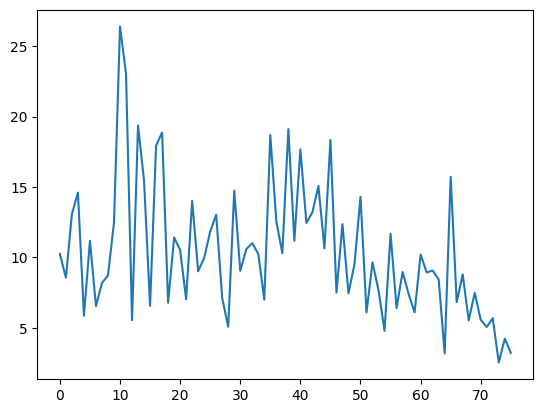

In [4]:
import matplotlib.pyplot as plt

# plt.plot(gradients_norm)
plt.plot([g[0] for g in gradients_norm])
# plt.plot([g[1] for g in gradients_norm])


# plt.plot([p[1] for p in predictions])

In [9]:

#print("Before optimization:")
#print(input_pos, input_dir)

# optimizer  = torch.optim.Adam(params=[input_pos, input_dir], lr=lrate)
# optimizer.step()
#print("\nAfter optimization:")
#print(input_pos, input_dir)

#print("\nObtained Gradients:")
#print(input_pos.grad, input_dir.grad)

Before optimization:
tensor([[-0.3713,  0.0227, -0.3024]], requires_grad=True) tensor([[-0.5231, -0.2513, -0.4255]], grad_fn=<SliceBackward0>)

Obtained Gradients:
tensor([[-8.7415, -8.6844, -6.0632]]) tensor([[5.3432, 0.7635, 2.7487]])

After optimization:
tensor([[-0.3613,  0.0327, -0.2924]], requires_grad=True) tensor([[-0.5331, -0.2613, -0.4355]], grad_fn=<AsStridedBackward0>)


# Working _Manual_ Gradient Walk

In [10]:
import matplotlib.pyplot as plt


actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_W, target_W
# actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_T, target_T
# actual_loc, actual_target, desired_loc, desired_target = loc_T, target_T, loc_B, target_B

trajectory     = [actual_loc]
gradients_norm = []
predictions    = []

n_steps        = 20
parsing_bar    = tqdm(range(n_steps))

gr_step = .5

for i in parsing_bar:
    pos_grad, dir_grad, prediction = get_gradient_from_location_and_output(actual_loc, desired_target)
    
    pos_grad_norm                  = np.linalg.norm(pos_grad)
    gradients_norm.append(pos_grad_norm)
    
    #actual_loc = actual_loc + pos_grad
    actual_loc = np.hstack([actual_loc[:3] - gr_step * pos_grad[0].numpy(), actual_loc[3:]])
    trajectory.append(actual_loc)
    
    perc_pred  = (prediction[0] + 1) / 2
    predictions.append(perc_pred)
    
    #parsing_bar.set_description(f"Water prediction {predictions[-1][1]:.4f}")
    parsing_bar.set_description(f"Gradient norm {pos_grad_norm:.4f}")

#     if pos_grad_norm < 1.184:
#         break
loc_B, actual_loc, desired_loc#, loc_W

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'get_gradient_from_location_and_output' is not defined

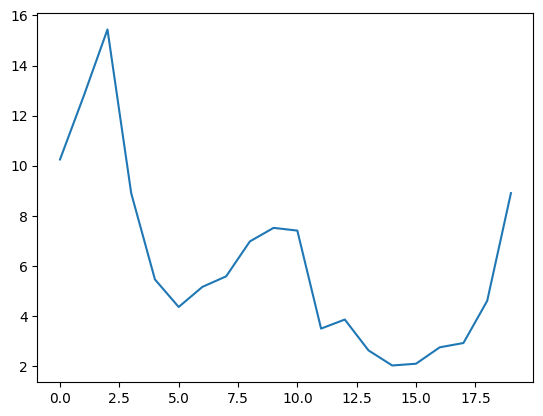

In [14]:
plt.plot(gradients_norm)


# plt.plot([p[1] for p in predictions])

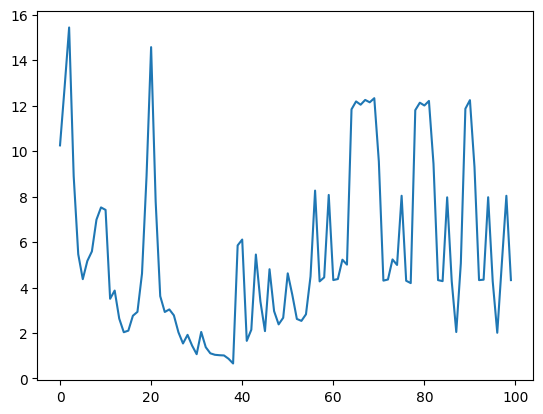

In [3]:
plt.plot(gradients_norm)


# plt.plot([p[1] for p in predictions])

# Working Plotting path on gradient

In [15]:
import open3d as o3d
import seaborn as sns


from utils.scripts.archive.scene_loading_2 import get_highlighed_o3d_locations
from utils.scripts.interest_heuristic_0    import get_o3d_pcd_from_coordinates

# sns.color_palette("coolwarm", as_cmap=True)
n_colors = 10
err_pallete = sns.color_palette("coolwarm", n_colors=n_colors)

initial_distance = np.linalg.norm(np.array(actual_loc[:3]) - np.array(desired_loc[:3]))

dist_to_color = lambda x : err_pallete[\
               int(9 * min(1, np.linalg.norm(np.array(actual_loc[:3]) - np.array(x[:3])) / initial_distance))]

# sns.palplot([dist_to_color(loc_A)])
# sns.palplot([dist_to_color(loc_B)])


trajectory_color = [dist_to_color(p) for p in trajectory]
trajectory_pcd = get_o3d_pcd_from_coordinates(np.vstack(trajectory)[:,:3], trajectory_color)


start_pcd  = get_highlighed_o3d_locations(actual_loc[:3], color=dist_to_color(actual_loc[:3]))[0]
target_pcd = get_highlighed_o3d_locations(desired_loc[:3], color=dist_to_color(desired_loc[:3]))[0]



o3d.visualization.draw_geometries([start_pcd, trajectory_pcd, target_pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


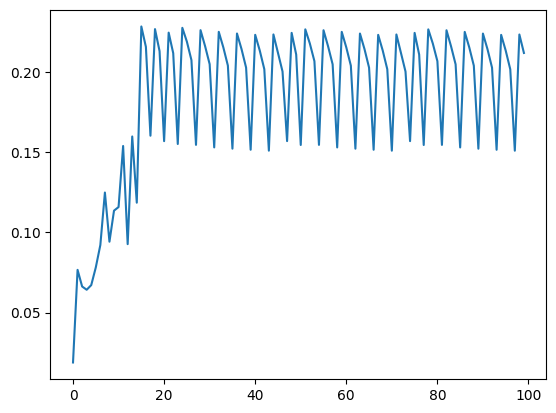

In [6]:


# plt.plot(gradients_norm)

plt.plot([p[1] for p in predictions])

# Motivation, why gradient should be a thing!

- In which papers is this hinted?
- Why not just jumping from one place to the next?


- What constitutes a good path?
    - the shortest path? (if points A and B are well defined)
    - Along the gradient? - Would this not get stuck in a local minima? - case in which A is defined, but destination B is hypothetical. 
    - maximizing availability to data (aside of some categories)?


    
Smootheness of camera movement?

In [1]:
import torch

# Taken from location_single_350_100_199_with_predictions.csv
mock_location = [349.039, 99.0, 199.612, -169.108, -53.737, -171.181]
# predicted - [0.15886150300502777, 0.41812682151794434, 0.12527874112129211, 0.2977328896522522]]

# target_location (+1 on y) - 349.039, 100.0, 199.612, -169.108, -53.737, -171.181
# mock_target   = [0.15875327587127686, 0.42250925302505493, 0.11981145292520523, 0.2989259660243988]
mock_target   = [0.15, 0.85, 0, 0]

far_away_target  = [0.15, 0.85, 0, 0]
# far_away_target  = torch.tensor([2*mt -1 for mt in far_away_target])

#(+1 on y)
close_target     = [0.15875327587127686, 0.42250925302505493, 0.11981145292520523, 0.2989259660243988]
# close_target     = torch.tensor([2*mt -1 for mt in close_target])

mock_target     = [2*mt -1 for mt in mock_target]

mock_target = close_target
mock_target = far_away_target



mock_location, mock_target

([349.039, 99.0, 199.612, -169.108, -53.737, -171.181], [0.15, 0.85, 0, 0])

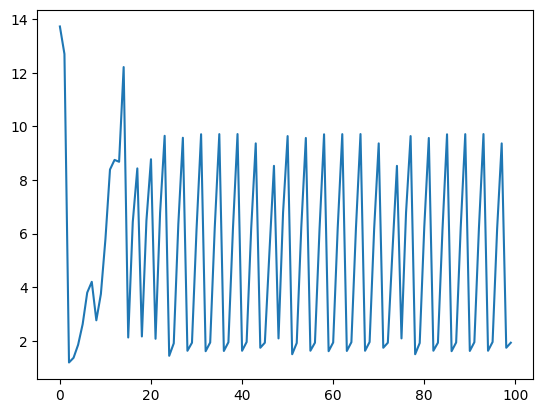

In [8]:
plt.plot(gradients_norm)

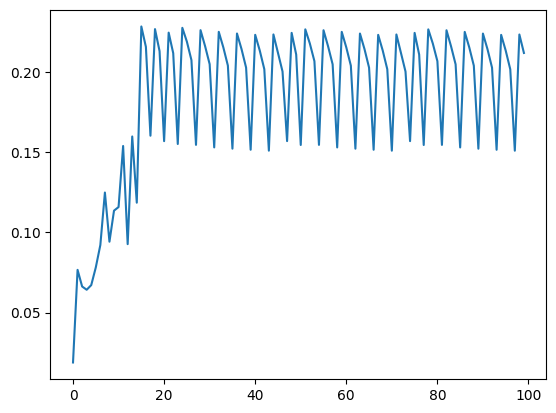

In [3]:
import matplotlib.pyplot as plt

# plt.plot(gradients_norm)
# Water predictions
plt.plot([p[1] for p in predictions])

# Development Drafts

What is the general term of the sequence [3, 10, 10, 11, −1, 14, −228, −357, −528, −747, −1020, −1353, −1752, −2223, −2772, −3405, −4128, −4947,−5868, −6897, −8040, −9303, −10692, −12213, −13872, −15675, −17628, −19737]?

What is the general term of the sequence [−228, −357, −528, −747, −1020, −1353, −1752, −2223, −2772, −3405, −4128, −4947,−5868, −6897, −8040, −9303, −10692, −12213, −13872, −15675, −17628, −19737]?

Can you evaluate the polynomial -x^3 - 2x in the integers between 6 all the way up to 9? How many evaluations do you need to make? Give me the list resulting from these evaluations.

Can you evaluate the polynomial -x^3 - 2x in 6, 7 and 8?

Can you evaluate -x^3 - 2x in 6?

What will be the next three terms in the following sequence:

What is the general term of the sequence 7 9 11 13 15?

What is the general term of the sequence 2 5 8 11 14?

What is the general term of the sequence 7 2 9 5 11 8 13 11 15 14?

What was the polynomial producing the following sequence [−228, −357, −528, −747, −1020, −1353, −1752, −2223, −2772, −3405, −4128, −4947,−5868, −6897, −8040, −9303, −10692, −12213, −13872, −15675, −17628, −19737]?

Can you evaluate the polynomial -x^3 - 2*x in the integers between 6 all the way up to 9? How many evaluations do you need to make? Give me the list resulting from these evaluations.

What is the general term of the sequence: [2, −6, −42, −148, −366, −738, −1306, −2112, −3198, −4606, −6378, −8556, −11182, −14298, −17946, −22168, −27006, −32502, −38698, −45636, −53358, −61906, −71322, −81648, −92926, −105198, −118506, −132892, −148398, −165066] ?    
    

# Optimizer approach adapted from iNeRF:

http://yenchenlin.me/inerf/

https://github.com/yenchenlin/iNeRF-public/blob/ab99c08cdbade1e92c152b6619c3066c01a4401b/pixel-nerf/pose_estimation.ipynb#L4

# Moved into `utils.gradient_walk_utils` - method:


`gradient_walk(actual_loc, desired_target, n_steps=10, loss_threshold=0, debugging_return=False, optimizer=None):`

In [85]:
from utils.gradient_walk_utils import get_gradient_from_location_and_output
import numpy as np
from tqdm.notebook import tqdm

# location_single_281_100_152_with_predictions
loc_B    = [280.2720261907330, 99.0, 152.49499332367300, -171.72398701418900, -63.62013971538380, -172.57562258088200]
target_B = [0.4373362958431244, 0.018862038850784302, 0.23208248615264893, 0.2356959581375122]

# location_single_316_100_169_with_predictions # location with water
loc_W    = [317.7068051391730, 100.0, 169.88643037743400, -171.72398701418900, -63.62013971538380, -172.57562258088200]
target_W = [0.26498448848724365, 0.11160671710968018, 0.2832949161529541, 0.2719825506210327]

# location_single_361_75_190_with_predictions - location with trees
loc_W    = [362.7868246127380, 74.2463380641929, 190.57535887016000, -143.4386147347180, -60.25751826014710, -147.2216146560020]
target_W = [0.16828903555870056, 0.030713021755218506, 0.47408124804496765, 0.051927417516708374]

# get_gradient_from_location_and_output(mock_location, mock_target)
# actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_W, target_W
# actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_T, target_T

# Closer locations - working better

In [3]:
from utils.gradient_walk_utils import get_gradient_from_location_and_output
import numpy as np
from tqdm.notebook import tqdm

loc_B    = [200.06402539249700, 130.766330167011, 148.70992037289600, -166.6068699698310, -54.17356605787240, -169.07315436340900]
target_B = [0.6230433583259583, 0.001851409673690796, 0.06430435180664062, 0.1719646453857422]

loc_B    = [292.0386197208470, 129.766330167011, 153.59994498944500, -165.8778459809970, -52.81646305112490, -168.66551861996300]
target_B = [0.363048255443573, 0.03436896204948425, 0.16084513068199158, 0.23941662907600403]

loc_T    = [321.6292486480970, 129.766330167011, 232.67945877255800, -166.60686996983100, -54.17356605787240, -169.07315436340900]
target_T = [0.1720944494009018, 0.36286360025405884, 0.12994933128356934, 0.3350926637649536]

loc_W    = [323.30009927537400, 129.766330167011, 176.59786501643500, -165.8778459809970, -52.81646305112490, -168.66551861996300]
target_W = [0.24161949753761292, 0.17246410250663757, 0.1669216752052307, 0.29214417934417725]

# actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_W, target_W
# actual_loc, actual_target, desired_loc, desired_target = loc_B, target_B, loc_T, target_T


In [2]:
from utils.gradient_walk_utils import initialize_trained_encoder, intialize_input_as_tensor
from utils.scripts.architectures.train_location_encoder import rescale_from_norm_params 
import torch

criterion       = torch.nn.MSELoss(reduction='none')


trained_encoder, info_dict = initialize_trained_encoder()

sample_batch               = intialize_input_as_tensor(actual_loc, desired_target, info_dict)
lrate = 1e-2#.05#1e-2#.05 #1e-2

loss_threshold = np.inf #.45

trajectory      = [np.array(actual_loc)]
gradients_norm  = []
predictions     = []
loss_trajectory = []


input_pos = torch.autograd.Variable(sample_batch["input_pos_raw"], requires_grad=True)
input_dir = sample_batch["input_dir_raw"]

optimizer  = torch.optim.Adam(params=[input_pos, input_dir], lr=lrate)

n_steps        = 100
parsing_bar    = tqdm(range(n_steps))

for i in parsing_bar:
    
    # project input_pos (and input_dir) on search space.
    
    
    ##### a. Predict output distribution
    output     = trained_encoder(input_pos, input_dir, from_raw=True)
    prediction = (output.detach().numpy())
    labels     = sample_batch["output"]

    ##### b. Compute loss
    loss      = criterion(output,labels)
    
    ##### c. Gradient step using optimizer:
    optimizer.zero_grad()
    loss.mean().backward()
    pos_grad, dir_grad = input_pos.grad, input_dir.grad
    optimizer.step()

    ##### d. Log found gradients and predictions
    loss_trajectory.append(loss.detach().numpy())
    
    pos_grad_norm     = (np.linalg.norm(pos_grad), np.linalg.norm(dir_grad))
    gradients_norm.append(pos_grad_norm)
    
    perc_pred         = (prediction[0] + 1) / 2
    predictions.append(perc_pred)
    
    parsing_bar.set_description(f"Gradient norm: loc {pos_grad_norm[0]:.4f}, dir {pos_grad_norm[0]:.4f}")
    
    ##### add location to trajectory
    scaled_loc = rescale_from_norm_params(input_pos.detach().numpy()[0], info_dict["xyz_centroid"], info_dict["xyz_max-min"])
    scaled_dir = rescale_from_norm_params(input_dir.detach().numpy()[0], info_dict["xyzh_centroid"], info_dict["xyzh_max-min"])
    
    actual_loc = np.hstack([scaled_loc, scaled_dir])
    #actual_loc = input_pos.detach().numpy()[0]
    trajectory.append(actual_loc)

    
    if loss.mean() < loss_threshold:
        break
    

  0%|          | 0/100 [00:00<?, ?it/s]

## Moved to `utils.gradient_walk_utils.py`

In [3]:

# Taken from location_single_350_100_199_with_predictions.csv
mock_location = [349.039, 99.0, 199.612, -169.108, -53.737, -171.181]
mock_target   = [0.15, 0.85, 0, 0]

# location_single_281_100_152_with_predictions
loc_A    = [280.2720261907330, 99.0, 152.49499332367300, -171.72398701418900, -63.62013971538380, -172.57562258088200]
target_A = [0.4373362958431244, 0.018862038850784302, 0.23208248615264893, 0.2356959581375122]

# location_single_316_100_169_with_predictions # location with water
loc_B    = [317.7068051391730, 100.0, 169.88643037743400, -171.72398701418900, -63.62013971538380, -172.57562258088200]
target_B = [0.26498448848724365, 0.11160671710968018, 0.2832949161529541, 0.2719825506210327]

# location_single_361_75_190_with_predictions - location with trees
loc_B    = [362.7868246127380, 74.2463380641929, 190.57535887016000, -143.4386147347180, -60.25751826014710, -147.2216146560020]
target_B = [0.16828903555870056, 0.030713021755218506, 0.47408124804496765, 0.051927417516708374]


# location_single_173_75_39_with_predictions = trees within buildings
loc_A    = [174.94570176880000	74.24633806419280	39.02996354213910	-143.318755841433	-60.34948900437360	-147.08363363844800]
target_A = [0.7874480485916138, 0.00013068318367004395, 0.1790778636932373, 0.01974925398826599]

get_gradient_from_location_and_output(mock_location, mock_target)

Input postion: tensor([[-0.3524,  0.0124, -0.2871]], requires_grad=True)
Input direction: tensor([[-0.5321, -0.2538, -0.4324]], grad_fn=<SliceBackward0>)
Predictions: [[-0.5908712  -0.10116171 -0.68952453 -0.47916803]]

Desired Output: tensor([[0.1500, 0.8500, 0.0000, 0.0000]])

Gradient to position: tensor([[-12.1792, -13.2660,  -7.7759]])
Gradient to direction: tensor([[-14.3884,  -2.9593,   1.0788]])


(tensor([[-12.1792, -13.2660,  -7.7759]]),
 tensor([[-14.3884,  -2.9593,   1.0788]]))

In [1]:
#1. Load trained model.
import os
from server import *
def initialize_trained_encoder():
    
    mv = 350                     #model version
    mp = "./utils/assets/models/"# path to models folder
    info_dict       = parse_training_info(mp, mv)
    trained_encoder = network.nerf.NeRF(pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"]\
        ,  view_dir_dim=info_dict["enc_input_size"], feat_dim=256)
    trained_encoder.load_state_dict(torch.load(f"{mp}/encoder_{mv}.pt"))
    
    return trained_encoder, info_dict

def intialize_input_as_tensor(mock_location, info_dict):
    
    
    norm_params     = (info_dict["xyz_centroid"], info_dict["xyz_max-min"], info_dict["xyzh_centroid"], info_dict["xyzh_max-min"])
    
    test_df    = pd.DataFrame(mock_location, ["x", "y", "z", "xh", "yh", "zh"]).T
    test_df["f_xyz"] = [mock_target]
    test_df["image_name"] = "no_image_name"
    test_name  = "_".join(test_df[["x", "y", "z"]].astype(int).values[0].astype(str))

    test_path = f"./utils/assets/test_data/location_single_{test_name}.csv"

    # test_df = curr_neigborhood
    test_df.to_csv(test_path, index=False)
    ml = True # skip label normalization
    test_df, _, _   = process_locations_visibility_data_frame(test_path, norm_params, selected_label_indexes=info_dict["sli"], missing_labels=ml)

    #1.Data loader from points
    ml = False # don't skip labels in the dataloader
    test_dl  = get_location_visibility_loaders(test_df, missing_labels=ml, only_test=True, batch_size=16, return_raw=True)

    sample_batch = test_dl.sampler.data_source[:1]
    
    return sample_batch

import torch

# Taken from location_single_350_100_199_with_predictions.csv
mock_location = [349.039, 99.0, 199.612, -169.108, -53.737, -171.181]
mock_target   = [0.15, 0.85, 0, 0]


In [4]:

def get_gradient_from_location_and_output(mock_location, mock_target):
    
    trained_encoder, info_dict = initialize_trained_encoder()

    sample_batch = intialize_input_as_tensor(mock_location, info_dict)
    
    #mock_target     = [0.15875327587127686, 0.42250925302505493, 0.11981145292520523, 0.2989259660243988]
    mock_target     = torch.tensor([2*mt -1 for mt in mock_target])

    # input_pos = sample_batch["input_pos_raw"]
    # https://discuss.pytorch.org/t/newbie-getting-the-gradient-with-respect-to-the-input/12709/2
    input_pos = torch.autograd.Variable(sample_batch["input_pos_raw"], requires_grad=True)
    input_dir = sample_batch["input_dir_raw"]


    #print("Input postion:", input_pos)
    #print("Input direction:", input_dir)
    output = trained_encoder(input_pos, input_dir, from_raw=True)
    #optimizer.zero_grad()
    prediction = (output.detach().numpy())

    # if gt_labels:
    labels    = sample_batch["output"]
    
    
    criterion       = torch.nn.MSELoss(reduction='none')
    loss      = criterion(output,labels)
    loss.mean().backward()

    #print("Predictions:", prediction)
    #print("\nDesired Output:", labels)

    #print("\nGradient to position:", input_pos.grad)
    #print("Gradient to direction:", input_dir.grad)
    
    return input_pos.grad, input_dir.grad

get_gradient_from_location_and_output(mock_location, mock_target)

(tensor([[-12.1792, -13.2660,  -7.7759]]),
 tensor([[-14.3884,  -2.9593,   1.0788]]))

close_target gradient - (+1 on y)

far_away_target gradient

In [2]:
#1. Load trained model.
import os
from server import *

mv = 350                     #model version
mp = "./utils/assets/models/"# path to models folder
info_dict       = parse_training_info(mp, mv)
norm_params     = (info_dict["xyz_centroid"], info_dict["xyz_max-min"], info_dict["xyzh_centroid"], info_dict["xyzh_max-min"])
trained_encoder = network.nerf.NeRF(pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"]\
    ,  view_dir_dim=info_dict["enc_input_size"], feat_dim=256)
trained_encoder.load_state_dict(torch.load(f"{mp}/encoder_{mv}.pt"))

# location to appropiate data format:
test_df    = pd.DataFrame(mock_location, ["x", "y", "z", "xh", "yh", "zh"]).T
test_df["f_xyz"] = [mock_target]
test_df["image_name"] = "no_image_name"
test_name  = "_".join(test_df[["x", "y", "z"]].astype(int).values[0].astype(str))

test_path = f"./utils/assets/test_data/location_single_{test_name}.csv"
# Generate points close to the 
# curr_loc           = test_df
# curr_neigborhood   = pd.concat(9*[curr_loc]).reset_index(drop=True) 

# neigborhood_deltas = np.hstack([
#             np.vstack([(i,j) for i in range(-1, 2) for j in range(-1, 2)]),\
#             np.zeros(9).reshape((-1, 1))\
# ])

# curr_neigborhood[["x", "y", "z"]] = curr_neigborhood[["x", "y", "z"]] + neigborhood_deltas

# test_df = curr_neigborhood
test_df.to_csv(test_path, index=False)
ml = True
test_df, _, _   = process_locations_visibility_data_frame(test_path, norm_params, selected_label_indexes=info_dict["sli"], missing_labels=ml)

ml = False
#1.Data loader from points
test_dl  = get_location_visibility_loaders(test_df, missing_labels=ml, only_test=True, batch_size=16, return_raw=True)


# #2. Encoder details
# _, criterion, optimizer, scheduler = get_location_visibility_encoder(info_dict["pos_enc_dim"], info_dict["num_present_classes"], feat_dim=256)


# os.remove(test_path)



#2. Pass input location 

#3. Return gradient with respect to what the input should look like to output



In [11]:
sample_batch = test_dl.sampler.data_source[:1]

# input_pos = sample_batch["input_pos_raw"]
# https://discuss.pytorch.org/t/newbie-getting-the-gradient-with-respect-to-the-input/12709/2
input_pos = torch.autograd.Variable(sample_batch["input_pos_raw"], requires_grad=True)
input_dir = sample_batch["input_dir_raw"]


print("Input postion:", input_pos)
print("Input direction:", input_dir)
output = trained_encoder(input_pos, input_dir, from_raw=True)
optimizer.zero_grad()
prediction = (output.detach().numpy())

# if gt_labels:
labels    = sample_batch["output"]
loss      = criterion(output,labels)
loss.mean().backward()

print("Predictions:", prediction)
print("\nDesired Output:", labels)

print("\nGradient to position:", input_pos.grad)
print("Gradient to direction:", input_dir.grad)

pos      = sample_batch["input_pos_raw"]#[:,0]
view_dir = sample_batch["input_dir_raw"]


# input_matrix   = np.vstack([vis_df[n[0]], vis_df[n[1]], vis_df[n[2]]\
#                             , vis_df[n[3]], vis_df[n[4]], vis_df[n[5]]]).T.astype(np.float32)

input_matrix = torch.vstack([pos[:, 0], pos[:, 1], pos[:, 2]\
                             , view_dir[:, 0], view_dir[:, 1], view_dir[:, 2]])

print(input_matrix)
                           

encoded_input = self.positional_encoder.encode(torch.tensor(input_matrix))
print(encoded_input)



Input postion: tensor([[-0.3524,  0.0124, -0.2871]], requires_grad=True)
Input direction: tensor([[-0.5321, -0.2538, -0.4324]], grad_fn=<SliceBackward0>)
Predictions: [[-0.5908712  -0.10116171 -0.68952453 -0.47916803]]
Desired Output: tensor([[-0.7000,  0.7000, -1.0000, -1.0000]])

Gradient to position: tensor([[-18.6906, -24.8154, -14.8778]])
Gradient to direction: tensor([[-10.0889,  -4.5091,   0.8392]])


In [23]:
e1 = test_dl.sampler.data_source[0]["input_pos"][:10]
print(f"Encoded input: {e1};")

freq_bands = 2 ** torch.arange(0.0, 10, dtype=torch.float32)

# decode = lambda e: torch.arcsin(e) / 2**0
decode = lambda e: torch.arcsin(e) / freq_bands

decode(e1)

Encoded input: tensor([-0.3451,  0.0124, -0.2832, -0.5073, -0.2511, -0.4191,  0.9386,  0.9999,
         0.9591,  0.8618]);


tensor([-0.3524,  0.0062, -0.0718, -0.0665, -0.0159, -0.0135,  0.0190,  0.0122,
         0.0050,  0.0020])